In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.fft import rfft, rfftfreq
import random

cur_dir = os.getcwd()

In [2]:
df = pd.read_csv(cur_dir + '//data//whole_dataset.csv', index_col='time')
print(df.shape)
df.head()

(900000, 5)


sensor1   sensor2  speed  load     fault
time                                                                 
2023-05-02 10:30:01.000000  2.518537  2.425404   25.0    80  No fault
2023-05-02 10:30:01.000200  2.516730  2.427211   25.0    80  No fault
2023-05-02 10:30:01.000400  2.514267  2.428032   25.0    80  No fault
2023-05-02 10:30:01.000600  2.516895  2.432796   25.0    80  No fault
2023-05-02 10:30:01.000800  2.520016  2.427375   25.0    80  No fault

### Getting sampling parameters

The dataset is relatively short(5 secs per run) to describe how the system(double-speed reduction gearbox) works and has too few operation modes to have significant amount of information about the system. There is significant amount of non-linear sources of vibration inside the gearbox that will show impact at speed the dataset doesn't contain. That's why an attempt to estimate speed outside provided range(8.3-40rps) will be a long shot.<br/>
As EDA showed, frequency spectrum is relatively easy to use for speed estimation. Spectrum of sensor 2 provides more useful information, but combined with sensor 1, the picture is even better.<br/>
Frequency range 0-50Hz will be examined, as this range contains vibration events, connected to gear rotations.<br/>
The dataset has short readings serieses for such noisy signals. 36 samples(1 per run) will not be enough to train a model. To generate more samples from each run, a moving window method will be used.<br/>
Let's decide what window size will provide enough information. Here an assumption is made that a good frequency chart will make possible speed estimation by eye.

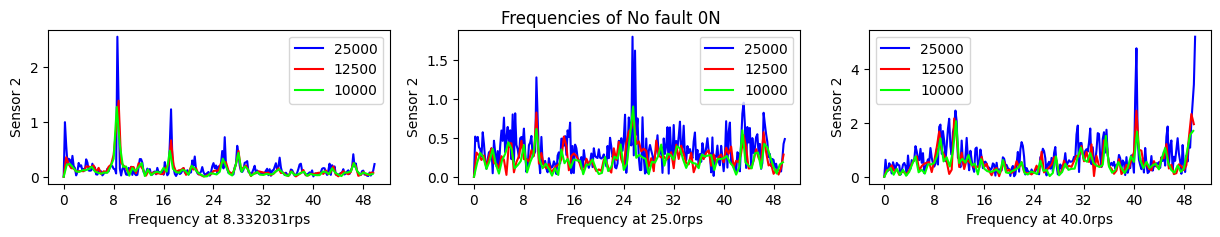

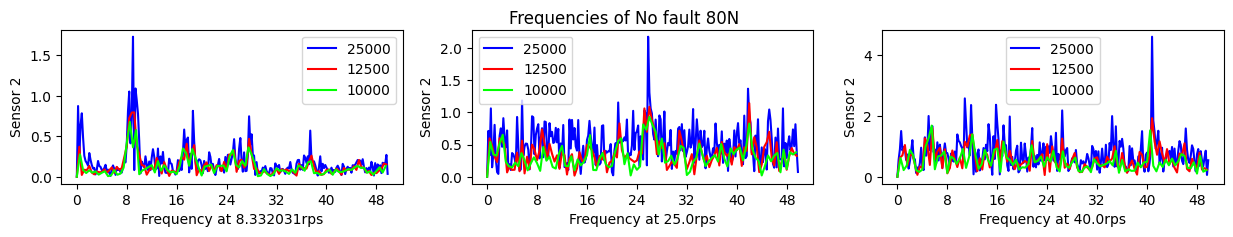

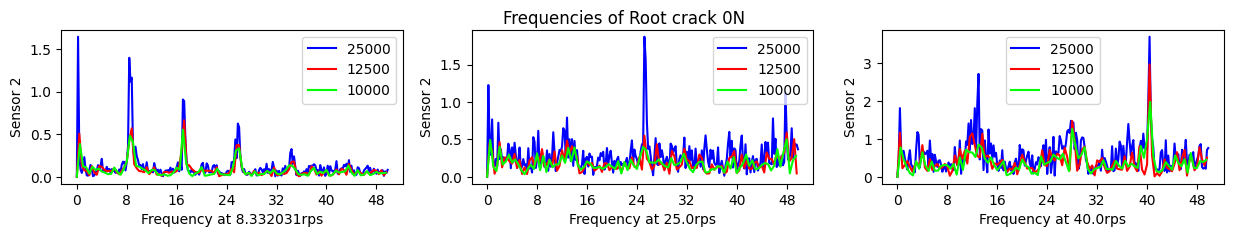

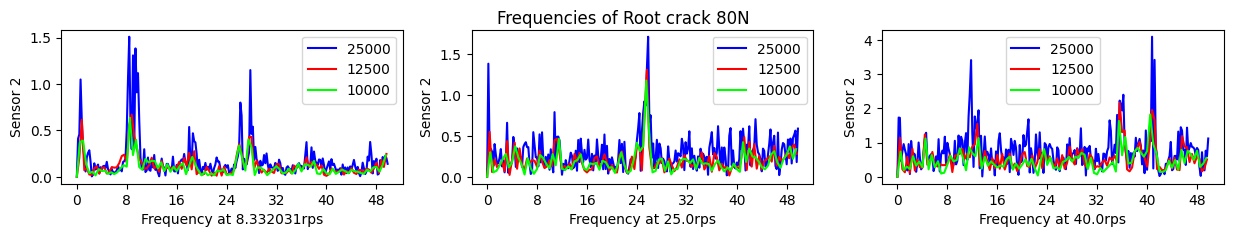

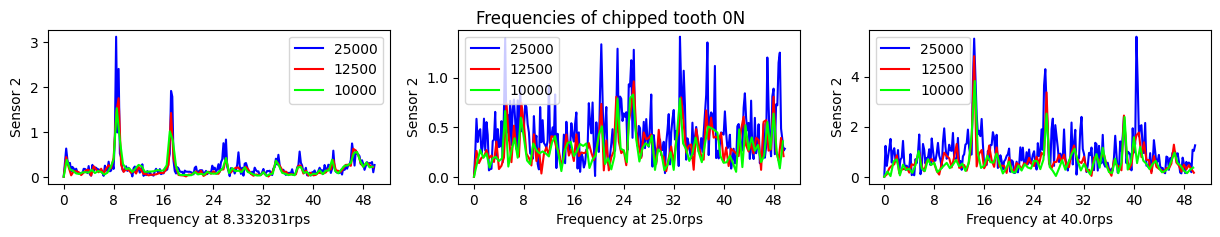

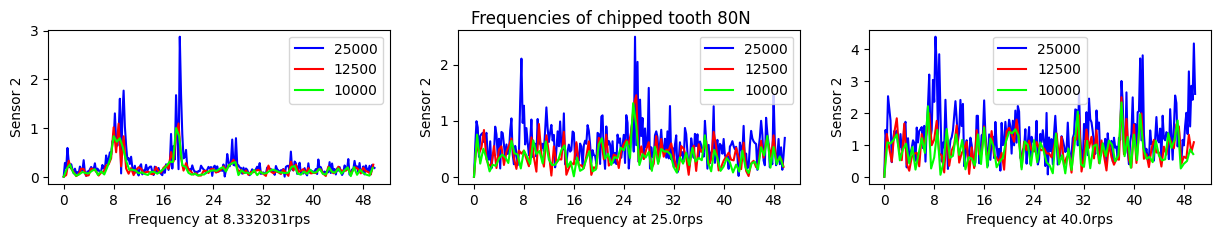

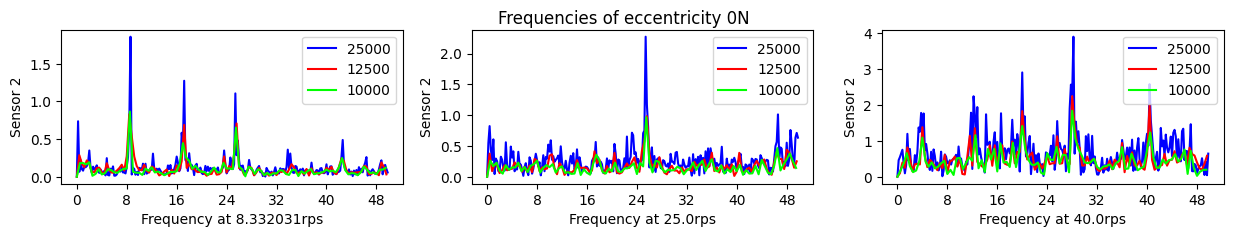

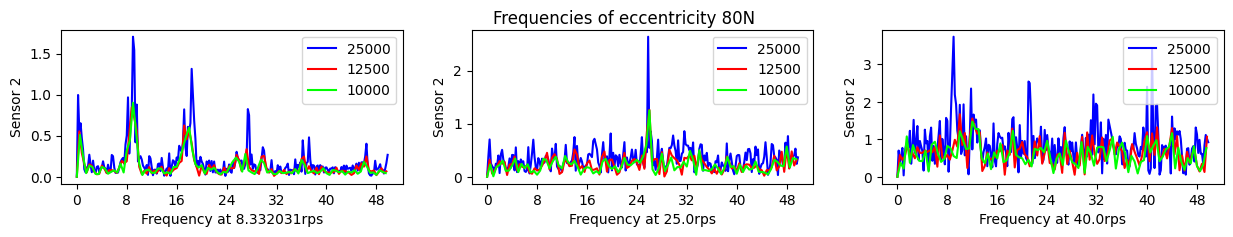

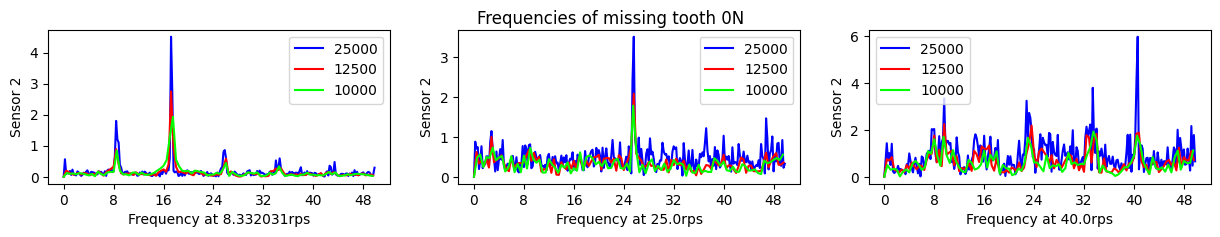

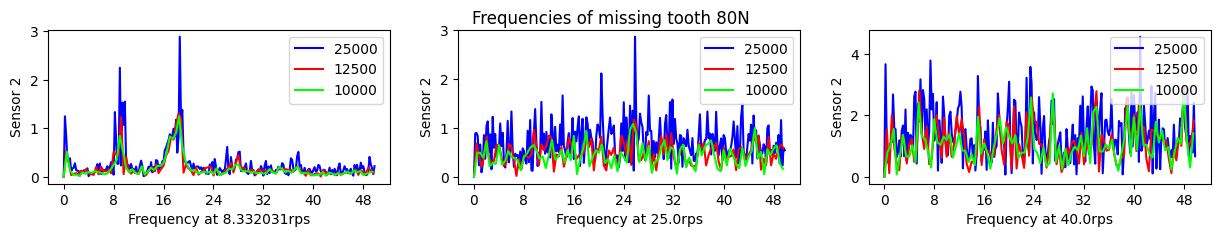

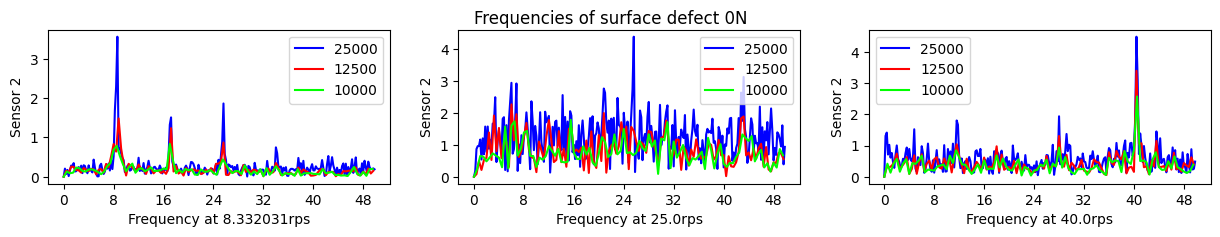

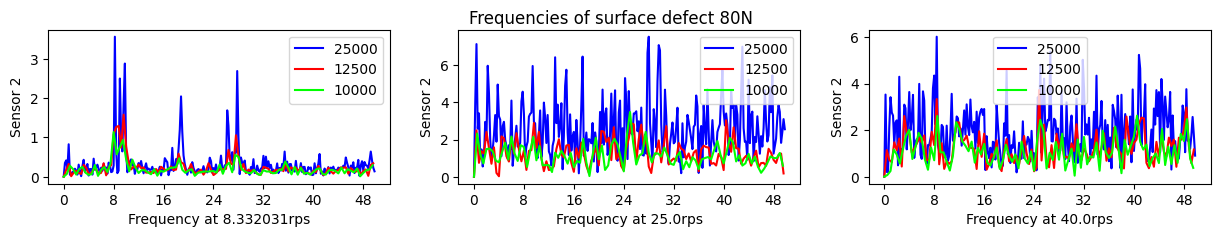

In [3]:
fault_lst = sorted(df['fault'].unique())
speed_lst = sorted(df['speed'].unique())
load_lst = sorted(df['load'].unique())

sns.set_palette(['blue', 'red', 'lime'])

for fault in fault_lst:
    for load in load_lst:
        fig, ax = plt.subplots(1, 3, figsize=(15, 2))
        fig.suptitle('Frequencies of ' + fault + ' ' + str(load) + 'N')
        
        for i, speed in enumerate(speed_lst):    
            measurements = df.loc[(df['fault'] == fault) & (df['load'] == load) & (df['speed'] == speed), 'sensor2']

            for length in [25000, 12500, 10000]:  # length of window          
                xf = rfftfreq(length, 1/5000) 
                xf = xf[xf < 50]  # frequency limit
                
                yf = rfft(measurements.values[:length])[:xf.size]  # getting only relevant values
                yf = np.abs(yf)
                yf[0] = 0           
                
                sns.lineplot(x=xf, y=yf, ax=ax[i], label=length)
                
            ax[i].set_xlabel('Frequency at ' + str(speed) + 'rps')
            ax[i].set_ylabel('Sensor 2')
            ax[i].set_xticks(range(0, 50, 8))            
        
        plt.show()

The plots were compared by simple criteria - having clear peak near target speed and having that peak as the highest on a plot. 12500 is easier to use as it has more clear peaks and on some plots only this window peaks show right speed.<br/>
Some plots have also some excessive peaks in the beginning and the end of selected frequency range(0-50). To fix that, another frequency range should be selected. 

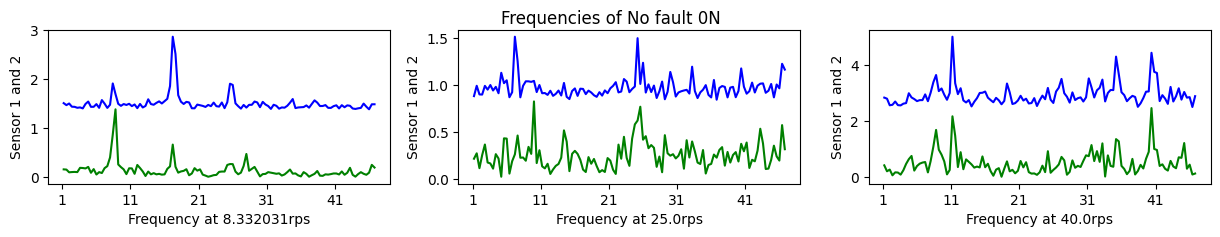

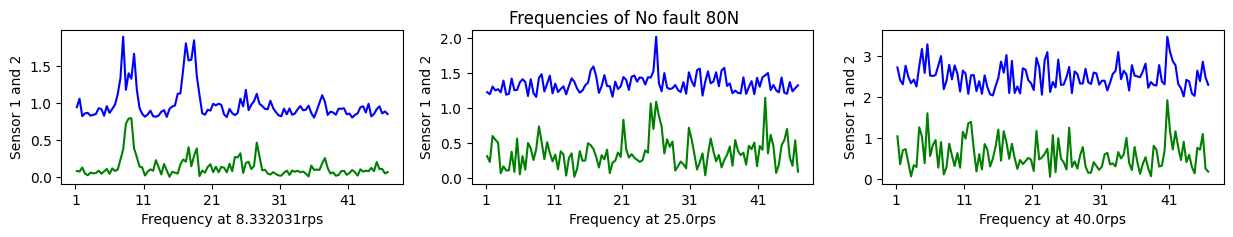

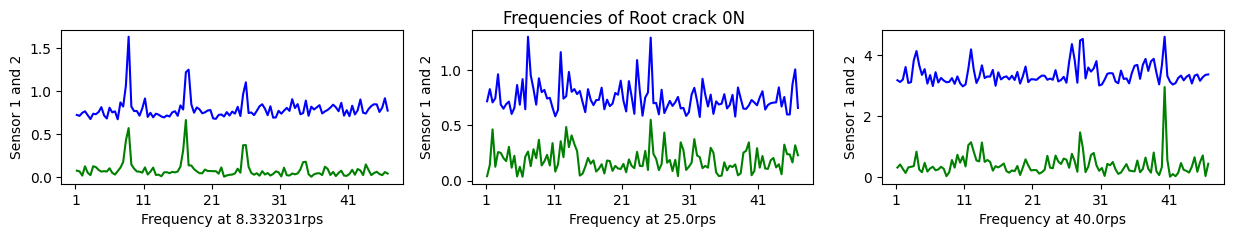

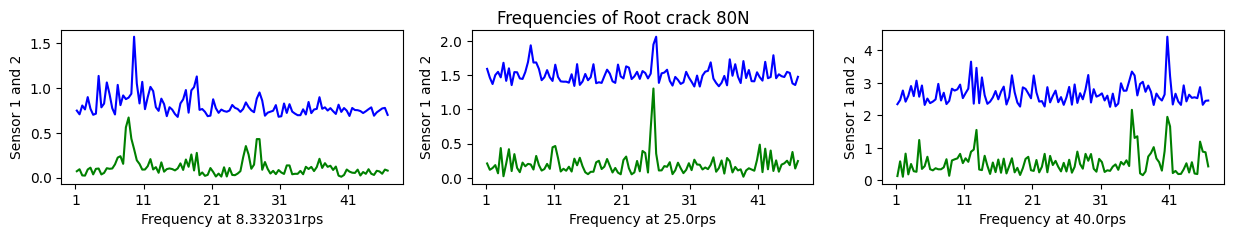

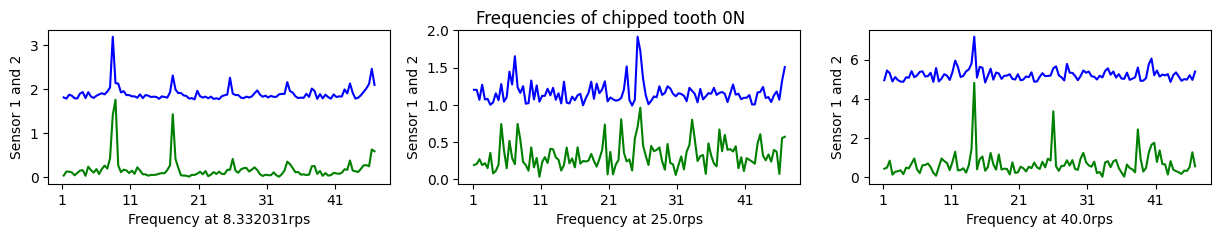

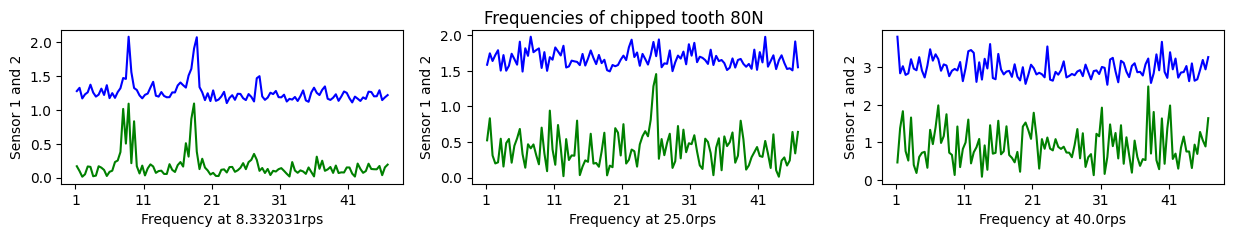

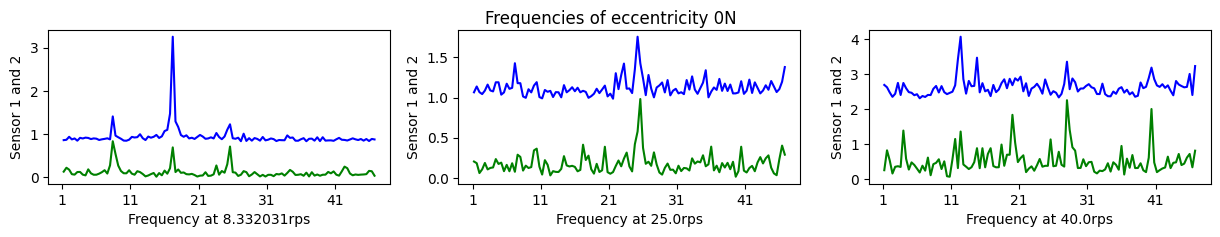

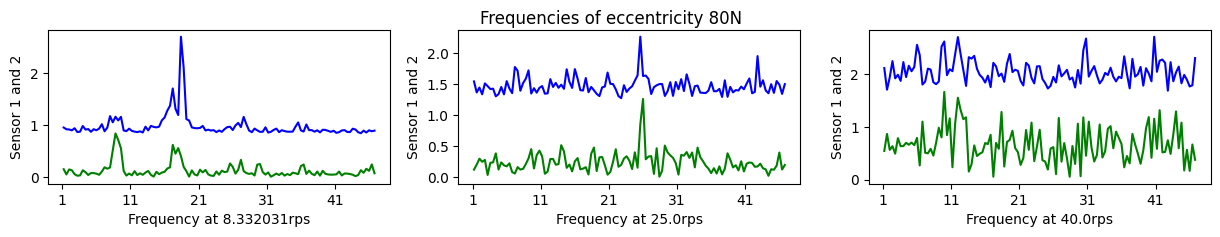

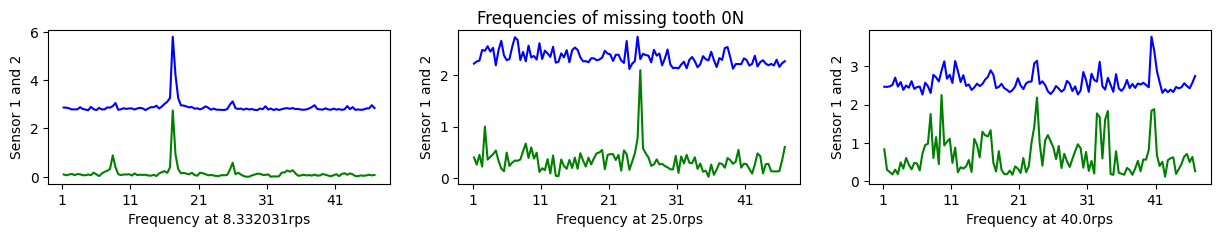

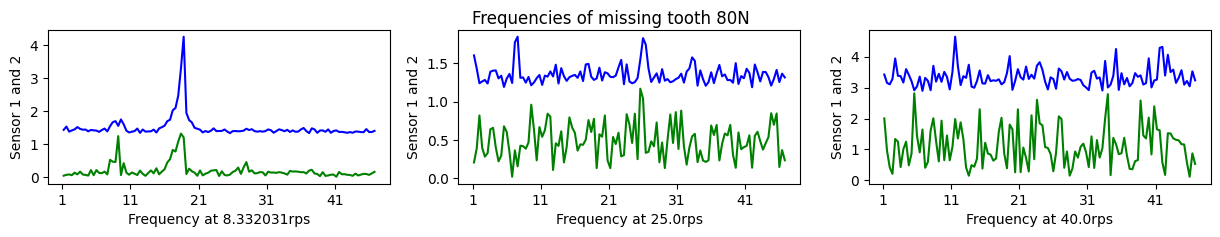

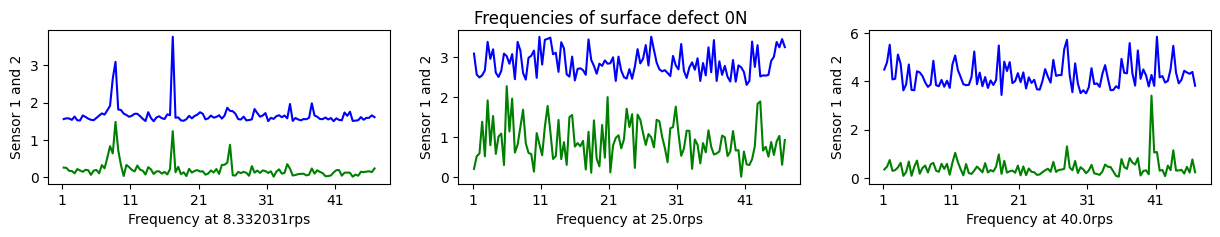

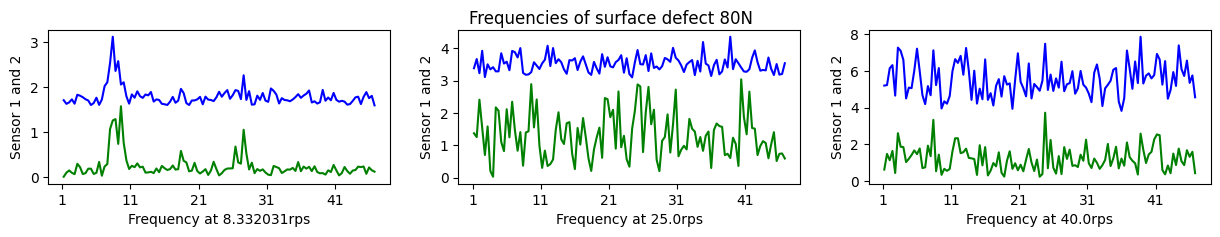

Freq index range: [3, 118]


In [4]:
freq_range = [1, 47]

xf = rfftfreq(12500, 1/5000) 
xf = xf[xf < freq_range[1]]  # getting data inside frequency range
xf_range = [0, xf.size]  # frequency range translated to frequency array elements
xf = xf[xf > freq_range[0]]
xf_range[0] = xf_range[1] - xf.size

for fault in fault_lst:
    for load in load_lst:
        fig, ax = plt.subplots(1, 3, figsize=(15, 2))
        fig.suptitle('Frequencies of ' + fault + ' ' + str(load) + 'N')        
        
        for i, speed in enumerate(speed_lst):    
            measurements = df.loc[(df['fault'] == fault) & (df['load'] == load) & (df['speed'] == speed)]
            
            yf = rfft(measurements['sensor2'].values[:12500])[xf_range[0]:xf_range[1]]
            yf = np.abs(yf) 
            sns.lineplot(x=xf, y=yf, ax=ax[i], color='g')
            
            offset = yf.max()  # offset to connviniently view both plots
            yf = rfft(measurements['sensor1'].values[:12500])[xf_range[0]:xf_range[1]]
            yf = np.abs(yf) + offset           
            sns.lineplot(x=xf, y=yf, ax=ax[i])
            
            ax[i].set_xlabel('Frequency at ' + str(speed) + 'rps')
            ax[i].set_ylabel('Sensor 1 and 2')          
            ax[i].set_xticks(range(freq_range[0], freq_range[1] + 1, 10))
        plt.show()

print('Freq index range:', xf_range)

Frequencies range [1, 47] removes unneeded peaks. [1, 47] represents [3, 118] range in frequencies array.<br/>
What frequency resolution does selected window provide?

In [5]:
print(rfftfreq(n=12500, d=1/5000)[:30])

[ 0.   0.4  0.8  1.2  1.6  2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2
  5.6  6.   6.4  6.8  7.2  7.6  8.   8.4  8.8  9.2  9.6 10.  10.4 10.8
 11.2 11.6]


What frequencies offset from target speed will contain needed frequency peak and some area around to see that this is a peak?

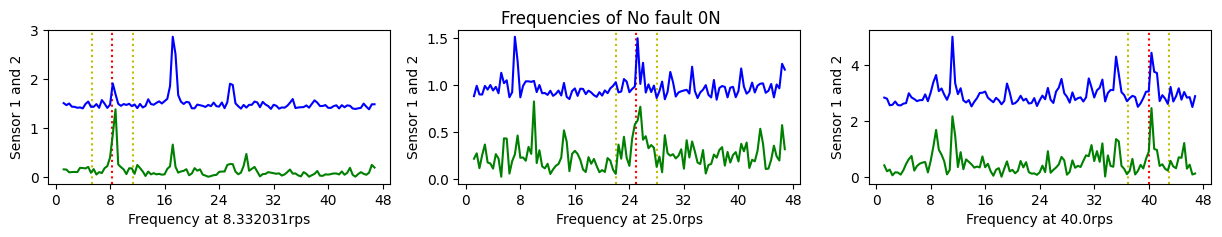

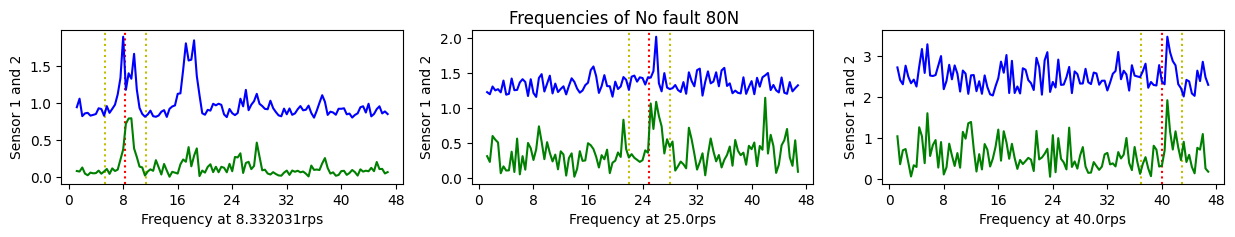

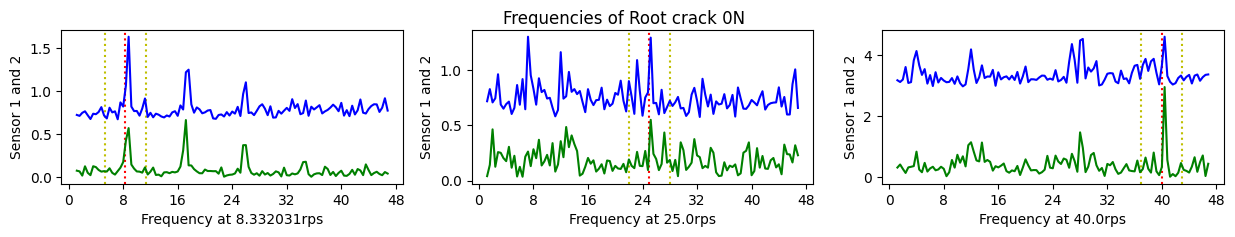

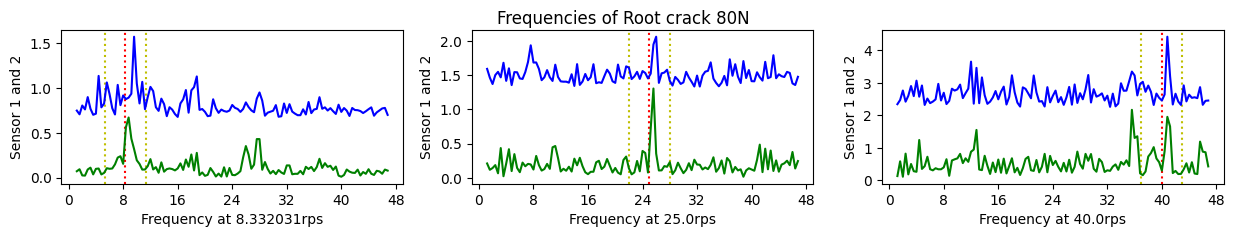

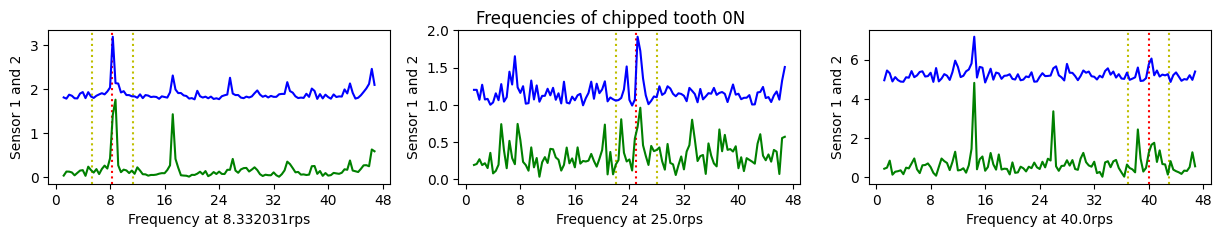

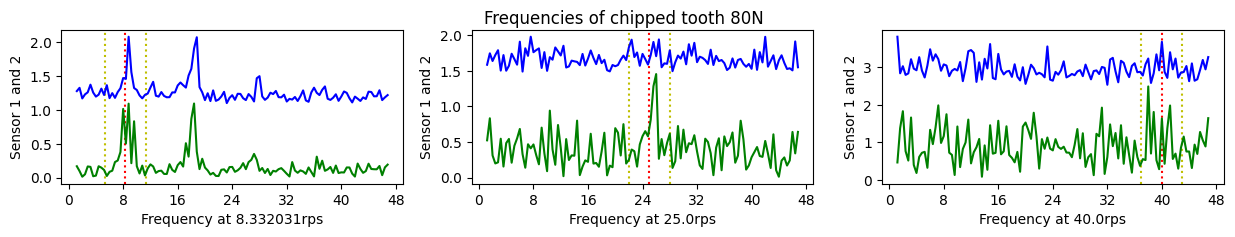

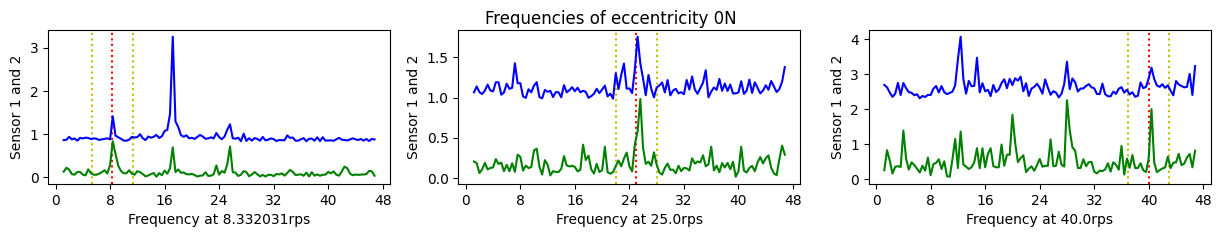

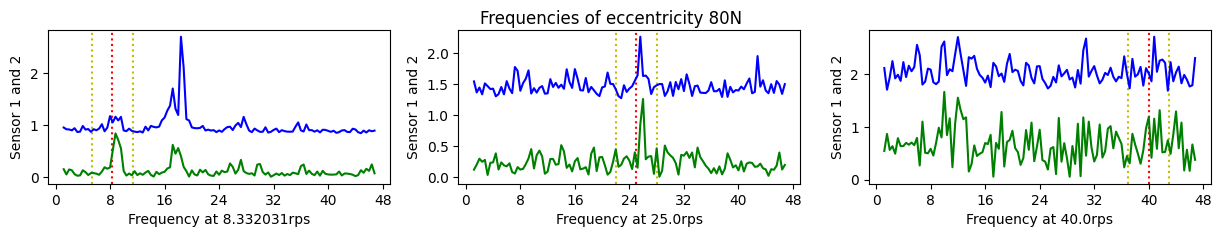

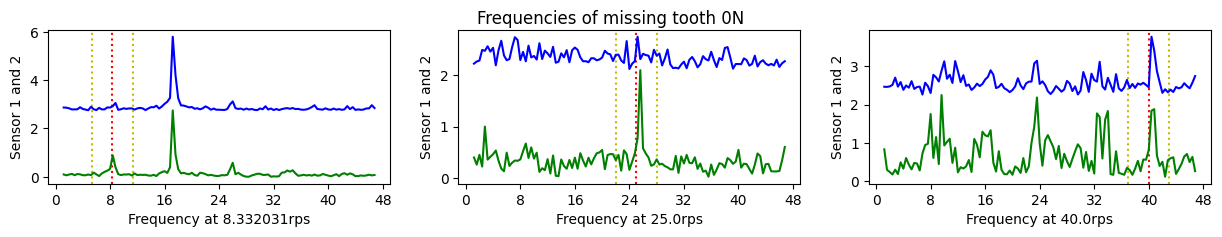

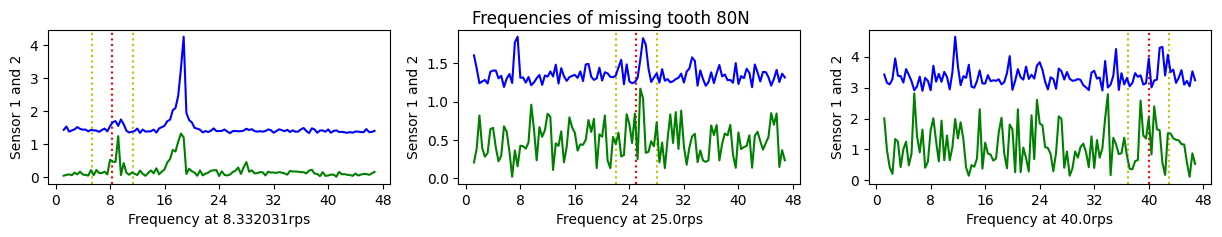

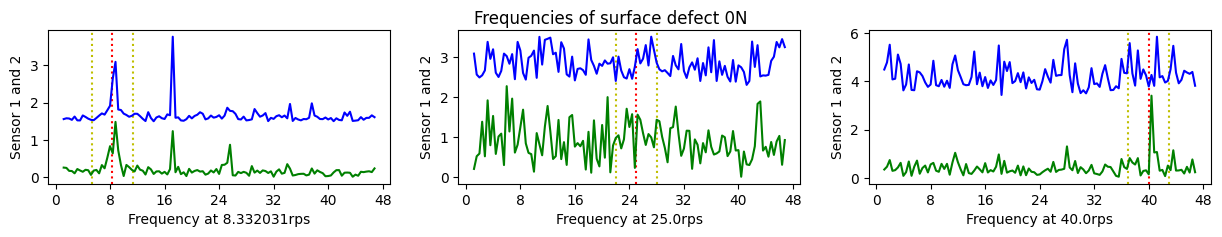

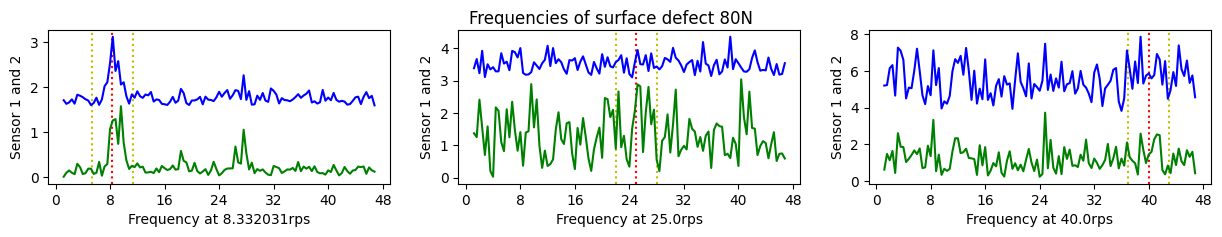

In [6]:
for fault in fault_lst:
    for load in load_lst:
        fig, ax = plt.subplots(1, 3, figsize=(15, 2))
        fig.suptitle('Frequencies of ' + fault + ' ' + str(load) + 'N')
        
        for i, speed in enumerate(speed_lst):  
            ax[i].axvline(x=speed, color='r', linestyle=':')  # rotation speed indicator
            ax[i].axvline(x=speed+3, color='y', linestyle=':')  # right offset
            ax[i].axvline(x=speed-3, color='y', linestyle=':')  # left offset
            
            measurements = df.loc[(df['fault'] == fault) & (df['load'] == load) & (df['speed'] == speed)] 
            
            yf = rfft(measurements['sensor2'].values[:12500])[xf_range[0]:xf_range[1]]            
            yf = np.abs(yf)
            sns.lineplot(x=xf, y=yf, ax=ax[i], color='g')
            
            offset = yf.max()
            yf = rfft(measurements['sensor1'].values[:12500])[xf_range[0]:xf_range[1]]
            yf = np.abs(yf) + offset              
            sns.lineplot(x=xf, y=yf, ax=ax[i])
            
            ax[i].set_xlabel('Frequency at ' + str(speed) + 'rps')
            ax[i].set_ylabel('Sensor 1 and 2') 
            ax[i].set_xticks(range(0, 50, 8))
        
        plt.show()

An offset of 3 to each side of target speed will contain peaks on all plots(where applicable), resulting in a 6Hz length window. How many readings in frequencies array does this window contain?

In [7]:
print('Peak window index length:', 6/0.4)

Peak window index length: 15.0


To generate as many training samples as possible, the window, size of which was defined earlier should move by reasonably small steps in order to create slightly different spectrums.

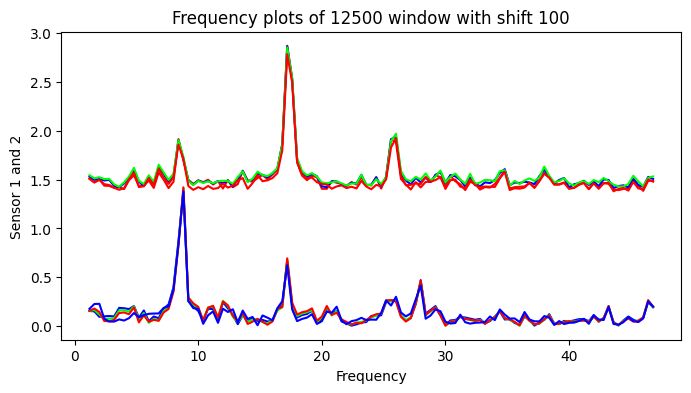

In [8]:
mov_step = 100
plt.rc("figure", figsize=(8, 4))  

measurements = df.loc[(df['fault'] == fault_lst[0]) & (df['load'] == load_lst[0]) & (df['speed'] == speed_lst[0])] 
for i in range(4):
    yf = rfft(measurements['sensor2'].values[mov_step*i:12500+mov_step*i])[xf_range[0]:xf_range[1]]            
    yf = np.abs(yf)
    sns.lineplot(x=xf, y=yf)
    
    offset = yf.max()
    yf = rfft(measurements['sensor1'].values[mov_step*i:12500+mov_step*i])[xf_range[0]:xf_range[1]]
    yf = np.abs(yf) + offset              
    sns.lineplot(x=xf, y=yf)

    plt.xlabel('Frequency')
    plt.ylabel('Sensor 1 and 2')
    plt.title('Frequency plots of 12500 window with shift 100')

Step of 100 readings should provide enough difference.

### Sampling

Based on previous findings, samples can be created.

In [9]:
freq_range_start = 3
freq_range_end = 118
freq_range = freq_range_end - freq_range_start
move = 100 
window_size = 12500

res = []

for speed in speed_lst:    
    for fault in fault_lst:    
        for load in load_lst:    
            run = df[(df['fault'] == fault) & (df['load'] == load) & (df['speed'] == speed)]

            for m in range(0, 25000 - window_size + 1, move):         
                sample = run.iloc[m:m + window_size]  # sliding window
                
                freq = rfft(sample['sensor1'].values) 
                freq = freq[freq_range_start:freq_range_end]
                freq = np.abs(freq)
                row = freq.tolist()   
                
                freq = rfft(sample['sensor2'].values) 
                freq = freq[freq_range_start:freq_range_end]
                freq = np.abs(freq)
                row += freq.tolist()
                
                row.append(load)
                row.append(fault)
                row.append(speed)
                row.append(m)  # window start position for debug
                
                res.append(row)
                
df_freq = pd.DataFrame(data=res, columns=[f's1_freq_{i}' for i in range(freq_range)] + 
                                         [f's2_freq_{i}' for i in range(freq_range)] + 
                                         ['load', 'fault', 'speed', 'window_start'])
df_freq.to_csv(cur_dir + '//data//df_freq.csv', index=False)
    
print('Dataset shape:', df_freq.shape)

Dataset shape: (4536, 234)


Now it's better to check if there were no errors by viewing random samples.

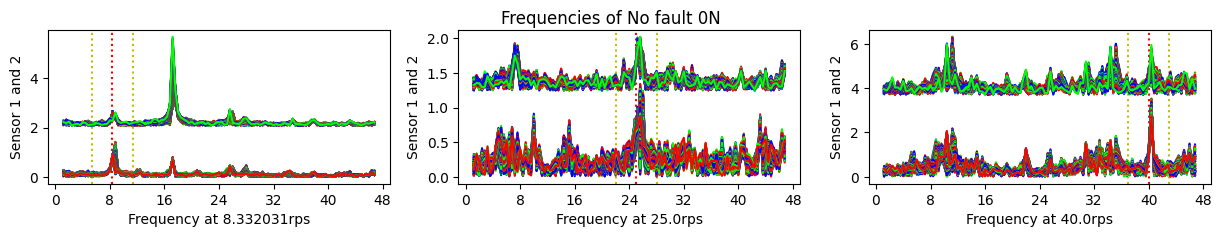

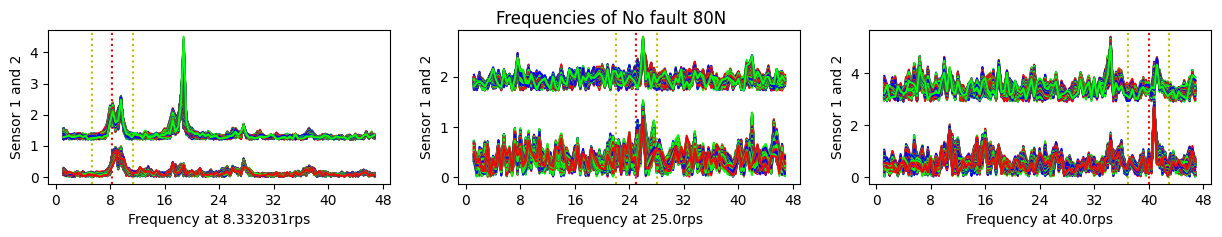

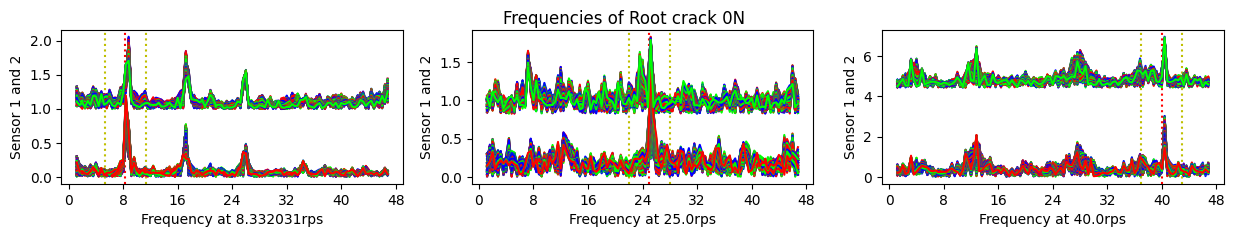

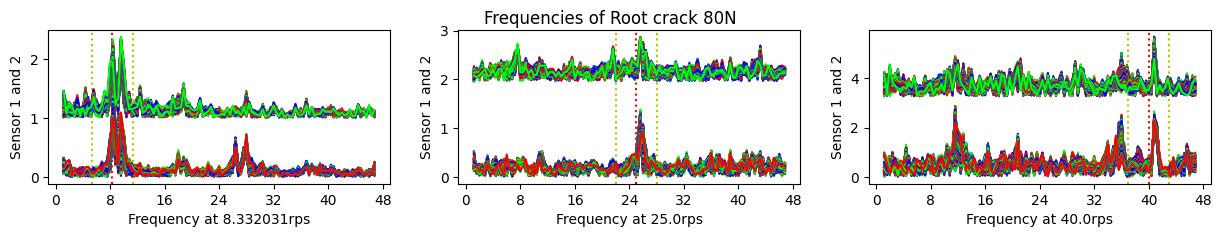

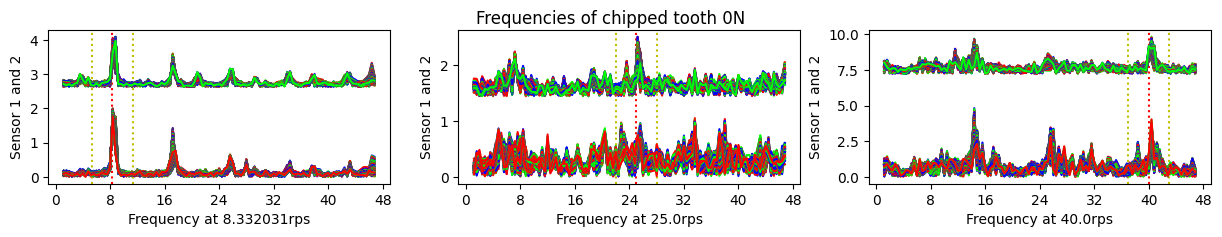

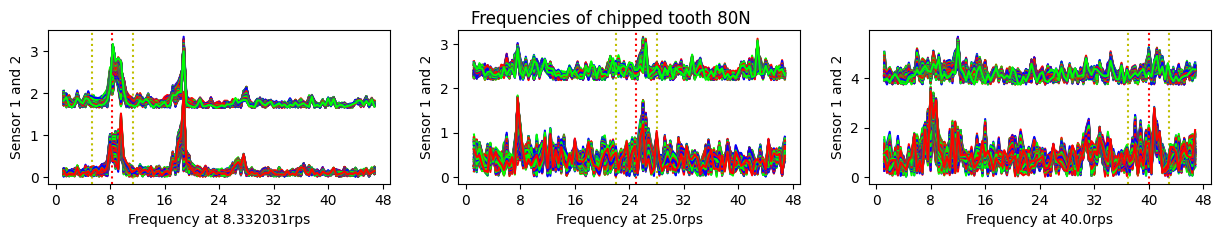

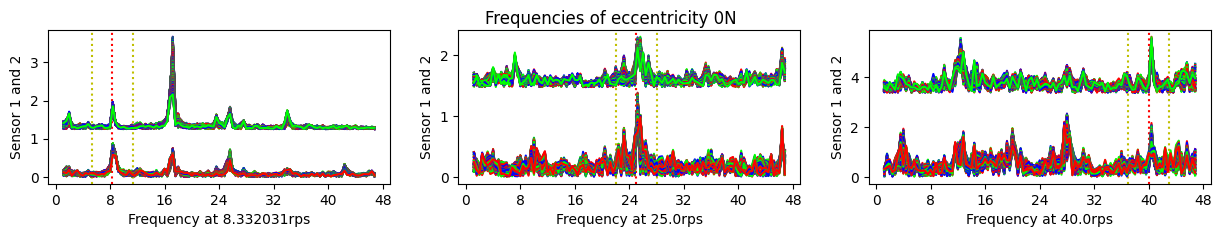

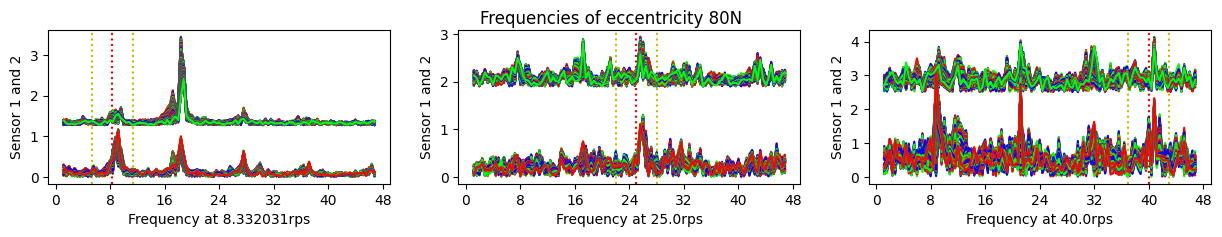

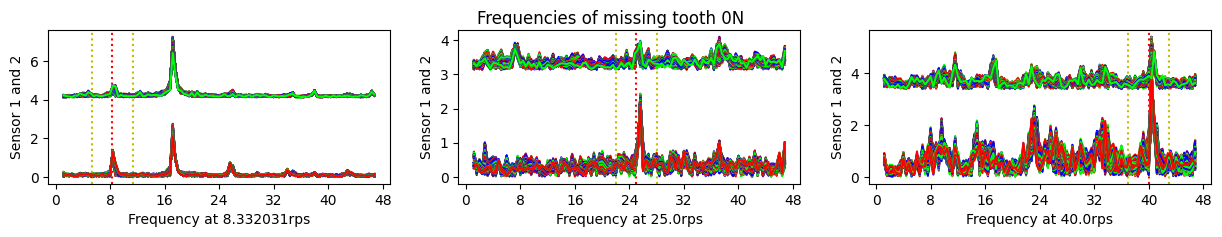

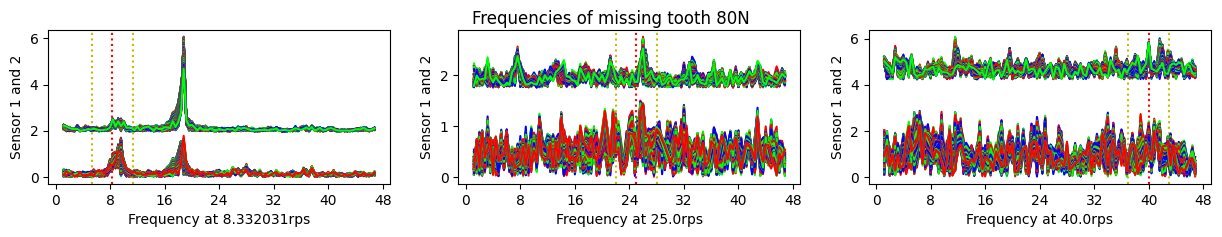

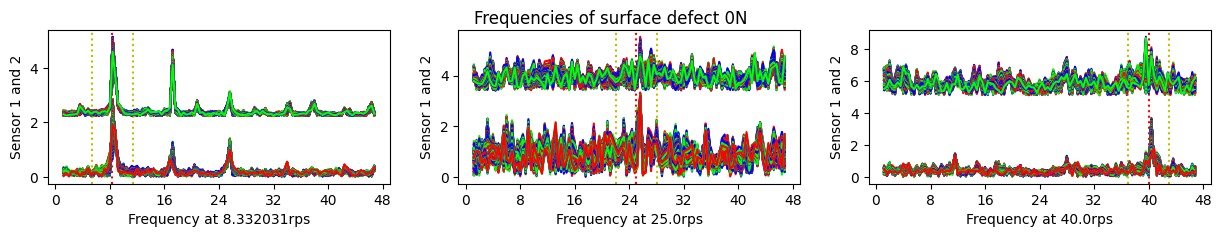

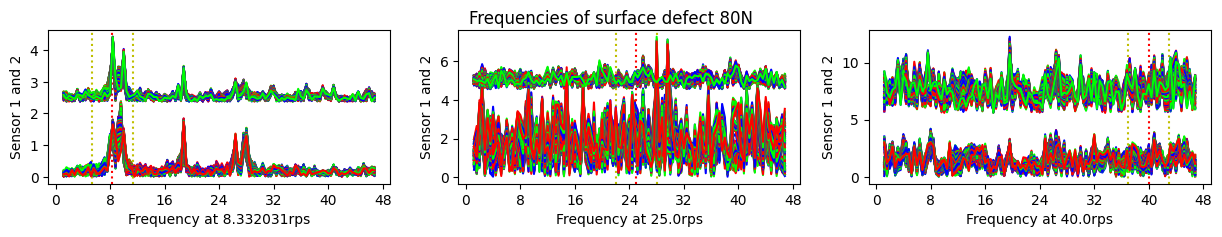

In [10]:
for fault in fault_lst:
    for load in load_lst:
        fig, ax = plt.subplots(1, 3, figsize=(15, 2))
        fig.suptitle('Frequencies of ' + fault + ' ' + str(load) + 'N')
        
        for i, speed in enumerate(speed_lst):  
            ax[i].axvline(x=speed, color='r', linestyle=':')
            ax[i].axvline(x=speed+3, color='y', linestyle=':')
            ax[i].axvline(x=speed-3, color='y', linestyle=':')
            
            measurements = df_freq.loc[(df_freq['fault'] == fault) & (df_freq['load'] == load) & 
                                       (df_freq['speed'] == speed)]
            offset = 0
            
            for row in measurements.values:
                yf = row[115:230]
                sns.lineplot(x=xf, y=yf, ax=ax[i])                
                
                if offset == 0:
                    offset = yf.max() * 1.5
                    
                yf = row[:115] 
                yf += offset         
                sns.lineplot(x=xf, y=yf, ax=ax[i])
                
                ax[i].set_xlabel('Frequency at ' + str(speed) + 'rps')
                ax[i].set_ylabel('Sensor 1 and 2') 
                ax[i].set_xticks(range(0, 50, 8))
        
        plt.show()

There plots are similar to other's so seems everything in fine.

### Generation of synthetic samples

4536 samples is not enough for the task, but what's more important, each of these samples is very similar to other samples of same run, which will likely make the model to overfit.<br/>
To overcome lack of data, synthetic samples could be generated. Unfortunately, the system has multiple sources of non-linear behavior, making any attempt to forecast spectrum useless.<br/>
As plots above show, almost every speed has frequency peaks near target speed. So, synthetic samples can be generated by shifting spectrums of real samples and proportionally calculating speed. Thus we can have multiple samples for each of non-existing in the dataset speeds, all of which will probably differ from real spectrums, but they will have different peaks at target speed. Training a model on such samples will force the model to detect main peaks, making it usable for real data.

In [11]:
rng = np.random.default_rng(42)
resolution = 0.4  # speed change per 1 array element
        
res = []

for row in df_freq[df_freq['speed'] == speed_lst[0]].values:     
    for i, speed in enumerate(np.arange(speed_lst[0] + resolution, 45, resolution), 1):
        new_row = rng.uniform(0, row[:freq_range-i].mean(), i).tolist()  # random spectrum to replace shifted values      
        new_row += row[:freq_range-i].tolist()  # real spectrum for sensor1
        new_row += rng.uniform(0, row[freq_range:freq_range*2-i].mean(), i).tolist()  # to replace shifted values  
        new_row += row[freq_range:freq_range*2-i].tolist()  # real spectrum for sensor2
        new_row += row[freq_range*2:freq_range*2+2].tolist()  # load and fault
        new_row += [speed]  # speed
        new_row += [speed_lst[0]]  # origin speed

        res.append(new_row) 
      
for row in df_freq[df_freq['speed'] == 25].values:        
    for i, speed in enumerate(np.arange(3, 25, resolution)[::-1], 1):    
        new_row = row[i:freq_range].tolist()  # real spectrum for sensor1
        new_row += rng.uniform(0, row[i:freq_range].mean(), i).tolist()  # random spectrum to replace shifted values  
        new_row += row[freq_range+i:freq_range*2].tolist()  # real spectrum for sensor2
        new_row += rng.uniform(0, row[freq_range+i:freq_range*2].mean(), i).tolist()  # to replace shifted values  
        new_row += row[freq_range*2:freq_range*2+2].tolist()  # load and fault
        new_row += [speed]  # speed
        new_row += [25]  # origin speed

        res.append(new_row)

    for i, speed in enumerate(np.arange(25 + resolution, 45, resolution), 1):
        new_row = rng.uniform(0, row[:freq_range-i].mean(), i).tolist()  # random spectrum to replace shifted values      
        new_row += row[:freq_range-i].tolist()  # real spectrum for sensor1
        new_row += rng.uniform(0, row[freq_range:freq_range*2-i].mean(), i).tolist()  # to replace shifted values  
        new_row += row[freq_range:freq_range*2-i].tolist()  # real spectrum for sensor2
        new_row += row[freq_range*2:freq_range*2+2].tolist()  # load and fault
        new_row += [speed]  # speed
        new_row += [25]  # origin speed

        res.append(new_row)

for row in df_freq[df_freq['speed'] == 40].values:        
    for i, speed in enumerate(np.arange(3, 40, resolution)[::-1], 1):    
        new_row = row[i:freq_range].tolist()  # real spectrum for sensor1
        new_row += rng.uniform(0, row[i:freq_range].mean(), i).tolist()  # random spectrum to replace shifted values  
        new_row += row[freq_range+i:freq_range*2].tolist()  # real spectrum for sensor2
        new_row += rng.uniform(0, row[freq_range+i:freq_range*2].mean(), i).tolist()  # to replace shifted values  
        new_row += row[freq_range*2:freq_range*2+2].tolist()  # load and fault
        new_row += [speed]  # speed
        new_row += [40]  # origin speed

        res.append(new_row)
        
df_synth = pd.DataFrame(data=res, columns=[f's1_freq_{i}' for i in range(freq_range)] + 
                                          [f's2_freq_{i}' for i in range(freq_range)] + 
                                          ['load', 'fault', 'speed', 'origin'])
df_synth.to_csv(cur_dir + '//data//df_synthetic_samples.csv', index=False)

print('Synthetic dataset shape:', df_synth.shape)

Synthetic dataset shape: (435456, 234)


Check by viewing random samples.

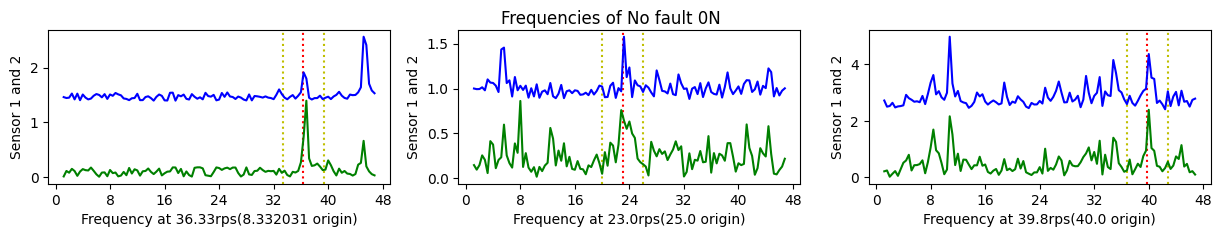

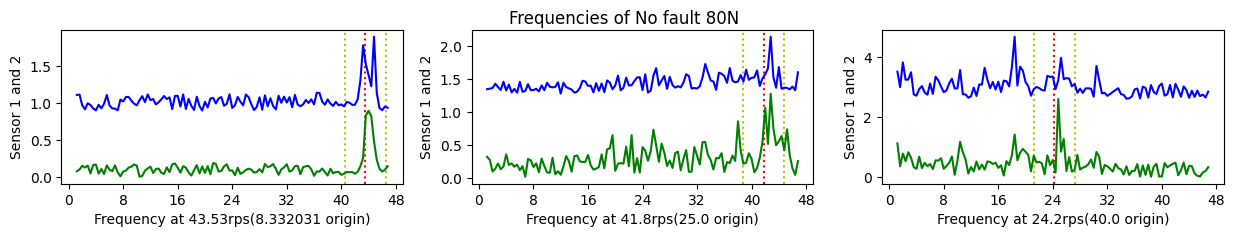

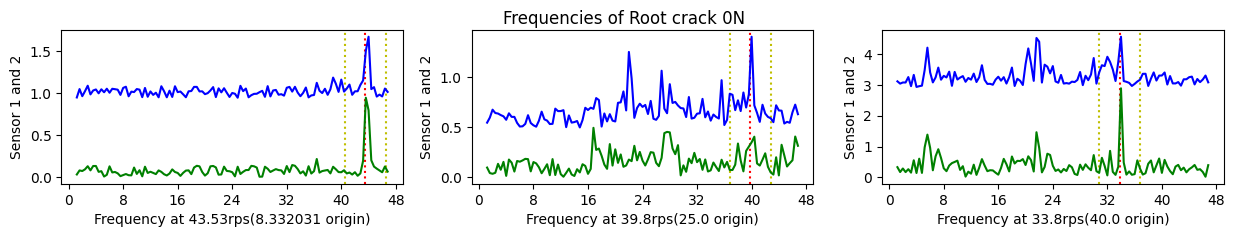

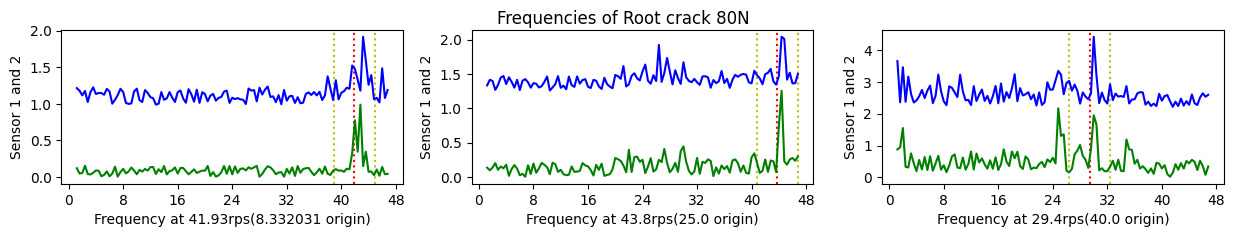

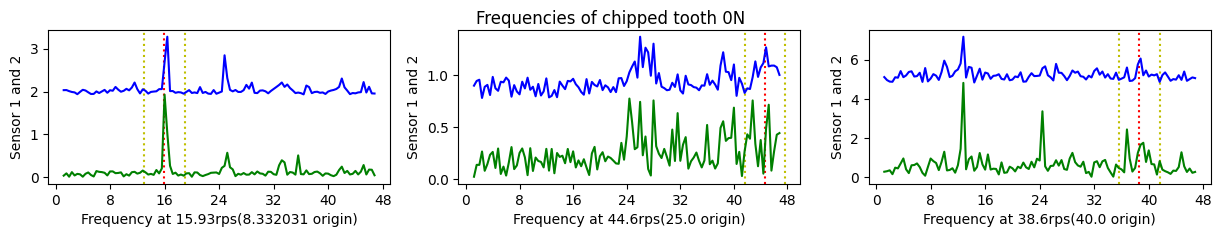

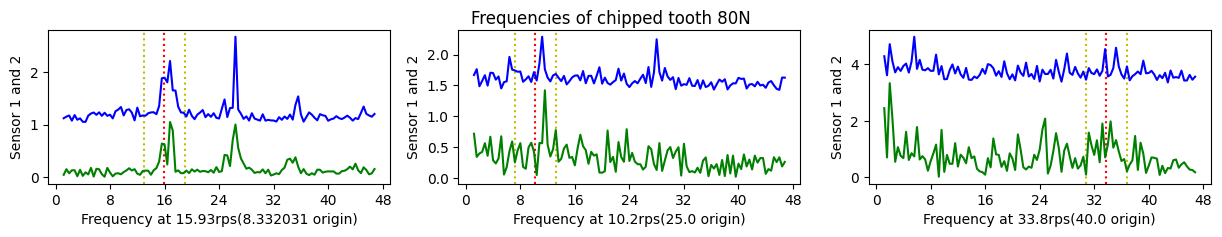

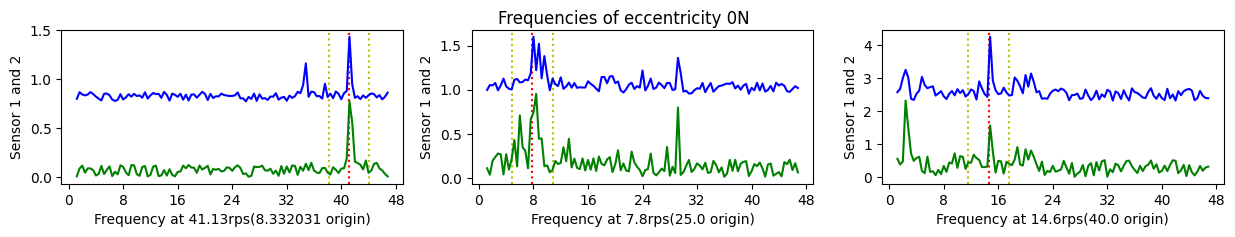

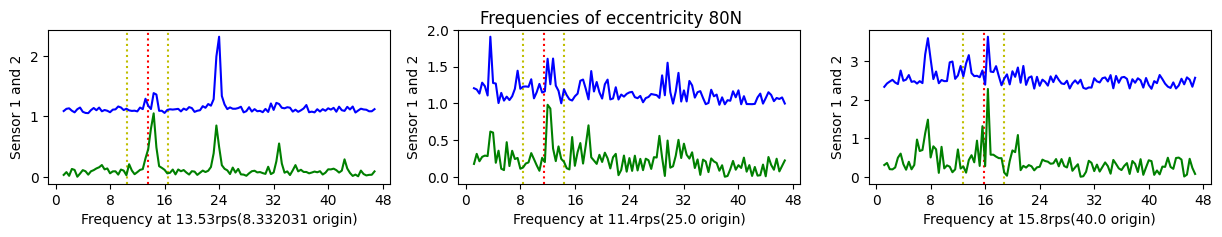

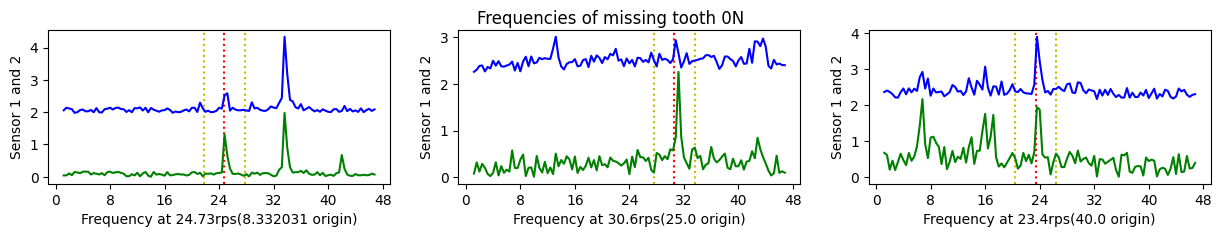

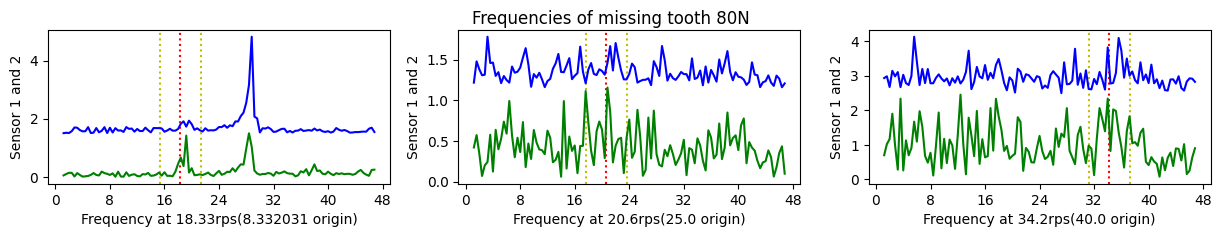

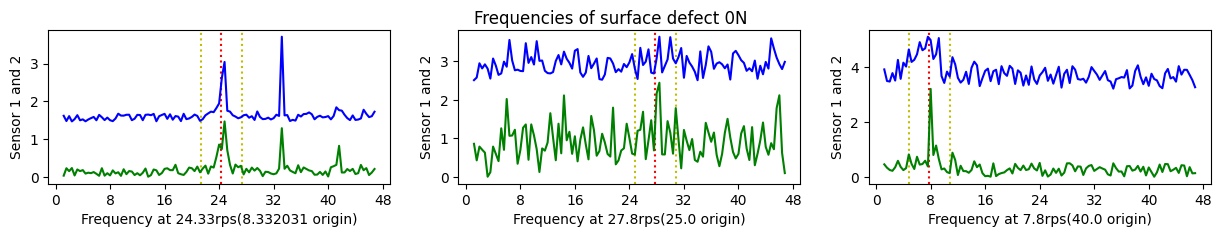

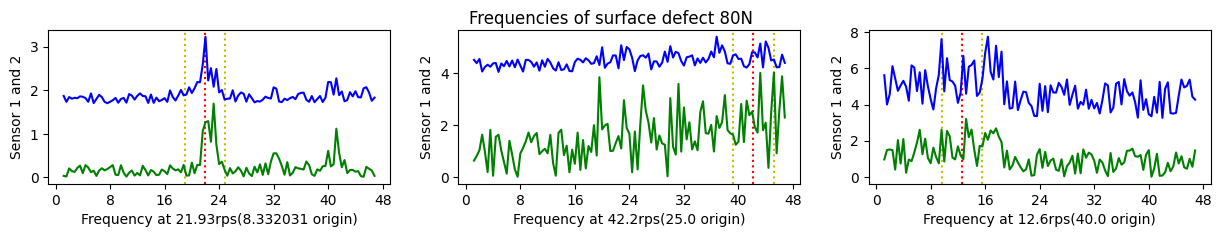

In [12]:
for fault in fault_lst:
    for load in load_lst:
        fig, ax = plt.subplots(1, 3, figsize=(15, 2))
        fig.suptitle('Frequencies of ' + fault + ' ' + str(load) + 'N')
        
        for i, origin in enumerate(speed_lst):               
            measurements = df_synth.loc[(df_synth['fault'] == fault) & (df_synth['load'] == load) & 
                                        (df_synth['origin'] == origin)].sample(1) 
            speed = measurements['speed'].item()
        
            ax[i].axvline(x=speed, color='r', linestyle=':')
            ax[i].axvline(x=speed+3, color='y', linestyle=':')
            ax[i].axvline(x=speed-3, color='y', linestyle=':')
            
            yf = measurements.iloc[:, 115:230].values[0]
            sns.lineplot(x=xf, y=yf, ax=ax[i], color='g')
            
            offset = yf.max()
            yf = measurements.iloc[:, :115].values[0]  
            yf += offset         
            sns.lineplot(x=xf, y=yf, ax=ax[i])
            
            ax[i].set_xlabel('Frequency at ' + str(round(speed, 2)) + 'rps(' + str(origin) + ' origin)')
            ax[i].set_ylabel('Sensor 1 and 2') 
            ax[i].set_xticks(range(0, 50, 8))
        
        plt.show()